<a href="https://colab.research.google.com/github/nmningmei/LevelUpPythonTutorial/blob/master/2_1_Pandas_and_behavioral_and_post_decoding_results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# This is how you are getting data from my Google Drive that I host. You cannot get this if you download this and run the script on your computer

In [0]:
# Import PyDrive and associated libraries.
# This only needs to be done once per notebook.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
def download_from_drive(id,name):
    downloaded = drive.CreateFile({'id':id})
    downloaded.GetContentFile('{}'.format(name))

In [0]:
behavioral_id = "https://drive.google.com/open?id=1t_rtpMCjeBfNUzGjYdOToLgtL1vv0-ki".split('id=')[-1]
behavioral_name = "sub-01.zip"
download_from_drive(behavioral_id,behavioral_name)
decode_id = "https://drive.google.com/open?id=15D_6P1fqGleg2ijV94Qw_RV_1HA2z8R6".split('id=')[-1]
decode_name = "decode.zip"
download_from_drive(decode_id,decode_name)

In [0]:
ls

adc.json  decode/  decode.zip  sample_data/  sub-01/  sub-01.zip


# This script is to show you have to manipulate tabulated data (data frame/ tables)

## this is how you upzip files with python

In [0]:
import zipfile
with zipfile.ZipFile("sub-01.zip", 'r') as zip_ref:
    zip_ref.extractall("sub-01")
with zipfile.ZipFile("decode.zip", 'r') as zip_ref:
    zip_ref.extractall("decode")

In [0]:
import os
from glob import glob
import pandas as pd
import numpy as np

from sklearn.metrics import roc_auc_score
from sklearn.utils import shuffle as sk_shuffle

from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
sns.set_context('poster')

from scipy import stats

from statsmodels.stats.multitest import multipletests

# Behavioral: 

1. masked images
2. pre-masks
3. post-masks
4. living v.s. nonliving
5. visibility rating

## define meta-context

1. working directory
2. working data in the directory

In [0]:
working_dir = 'sub-01/sub-01'
working_data = glob(os.path.join(working_dir,'*','*.csv'))
print(working_data)

['sub-01/sub-01/session-04/sub-01_unfeat_run-05.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-09.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-62.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-01.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-08.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-03.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-61.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-07.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-04.csv', 'sub-01/sub-01/session-04/sub-01_unfeat_run-02.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-05.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-09.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-01.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-08.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-03.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-07.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-06.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-04.csv', 'sub-01/sub-01/session-06/sub-01_unfeat_run-0

## The next cell is the same as the next one: one-line for-loop

In [0]:
df = []
for ii,f in enumerate(working_data):
    temp = pd.read_csv(f).iloc[:32:]
    temp['run'] = ii
    df.append(temp)
df = pd.concat(df)
print(df.head())

           category index  ... order run
0  Nonliving_Things     3  ...   6.0   0
1  Nonliving_Things    62  ...  19.0   0
2  Nonliving_Things     0  ...   7.0   0
3     Living_Things    57  ...  24.0   0
4     Living_Things    48  ...  11.0   0

[5 rows x 39 columns]


In [0]:
def read_csv(f,ii):
    temp = pd.read_csv(f).iloc[:32,:]
    temp['run'] = ii
    return temp
df = pd.concat([read_csv(f,ii) for ii,f in enumerate(working_data)])
print(df.head())

           category index  ... order run
0  Nonliving_Things     3  ...   6.0   0
1  Nonliving_Things    62  ...  19.0   0
2  Nonliving_Things     0  ...   7.0   0
3     Living_Things    57  ...  24.0   0
4     Living_Things    48  ...  11.0   0

[5 rows x 39 columns]


## take a look at the columns

In [0]:
df.columns

Index(['category', 'index', 'probe_path', 'subcategory', 'label', 'n',
       'correctAns_mean', 'correctAns_raw', 'discrim_resptime_mean',
       'discrim_resptime_raw', 'discrim_resptime_std', 'image_onset_time_mean',
       'image_onset_time_raw', 'image_onset_time_std', 'jitter1_mean',
       'jitter1_raw', 'jitter2_mean', 'jitter2_raw', 'probe_Frames_raw',
       'response.corr_mean', 'response.corr_raw', 'response.corr_std',
       'response.keys_raw', 'response.rt_mean', 'response.rt_raw',
       'response.rt_std', 'response_window_raw', 'visible.corr_mean',
       'visible.corr_raw', 'visible.corr_std', 'visible.keys_raw',
       'visible.rt_mean', 'visible.rt_raw', 'visible.rt_std',
       'visible_resptime_mean', 'visible_resptime_raw', 'visible_resptime_std',
       'order', 'run'],
      dtype='object')

In [0]:
df[['probe_Frames_raw','visible.keys_raw']]

,probe_Frames_raw,visible.keys_raw
0,1,'1'
1,3,'3'
2,2,'2'
3,3,'1'
4,4,'2'
...,...,...
27,4,'3'
28,1,'1'
29,1,'1'
30,1,'1'


In [0]:
df['probe_Frames_raw']

0     1
1     3
2     2
3     3
4     4
     ..
27    4
28    1
29    1
30    1
31    2
Name: probe_Frames_raw, Length: 1760, dtype: object

In [0]:
def str2int(x):
    """
    convert strings to numbers
    """
    import re
    if type(x) is str:
        return float(re.findall(r'\d+',x)[0])
    else:
        return x

In [0]:
df['probe_Frames_raw'].apply(str2int)

0     1.0
1     3.0
2     2.0
3     3.0
4     4.0
     ... 
27    4.0
28    1.0
29    1.0
30    1.0
31    2.0
Name: probe_Frames_raw, Length: 1760, dtype: float64

In [0]:
target_columns = ['probe_Frames_raw','response.keys_raw','visible.keys_raw','correctAns_raw']
for col in target_columns:
    df[col] = df[col].apply(str2int)

In [0]:
df[target_columns]

,probe_Frames_raw,response.keys_raw,visible.keys_raw,correctAns_raw
0,1.0,1.0,1.0,2.0
1,3.0,2.0,3.0,2.0
2,2.0,2.0,2.0,2.0
3,3.0,2.0,1.0,2.0
4,4.0,2.0,2.0,1.0
...,...,...,...,...
27,4.0,2.0,3.0,2.0
28,1.0,1.0,1.0,1.0
29,1.0,2.0,1.0,2.0
30,1.0,1.0,1.0,1.0


In [0]:
df = df.sort_values(['run','order'])

## questions:

1. how many times the subjects select each visibility ratings?
2. what is the probability the subject press "1" and "2" to respond to living vs nonliving that appear randomly left or right on the screen given a visibility ratings?
3. correct rate given each visibility rating?

In [0]:
def compute_accuracy_permutation(df_sub,n_permutation = 100):
    np.random.seed(12345)
    res = []
    chance = []
    for _ in range(n_permutation):
        idx_ = np.random.choice(df_sub.shape[0],size = 1000,replace = True)
        responses = df_sub['response.keys_raw'].values[idx_]
        corrects = df_sub['correctAns_raw'].values[idx_]
        score = roc_auc_score(corrects,responses)
        res.append(score)
        score = roc_auc_score(corrects,sk_shuffle(responses))
        chance.append(score)
    return res,chance

### How to make this for-loop faster? Parallelize it.

In [0]:
def resample_ttest(x,baseline = 0.5,n_ps = 100,n_permutation = 10000,one_tail = False,
                   n_jobs = -1, verbose = 0):
    """
    http://www.stat.ucla.edu/~rgould/110as02/bshypothesis.pdf
    https://www.tau.ac.il/~saharon/StatisticsSeminar_files/Hypothesis.pdf
    Inputs:
    ----------
    x: numpy array vector, the data that is to be compared
    baseline: the single point that we compare the data with
    n_ps: number of p values we want to estimate
    one_tail: whether to perform one-tailed comparison
    """
    import numpy as np
    # t statistics with the original data distribution
    t_experiment = (np.mean(x) - baseline) / (np.std(x) / np.sqrt(x.shape[0]))
    null            = x - np.mean(x) + baseline # shift the mean to the baseline but keep the distribution
    from joblib import Parallel,delayed
    import gc
    gc.collect()
    def t_statistics(null,size,):
        """
        null: shifted data distribution
        size: tuple of 2 integers (n_for_averaging,n_permutation)
        """
        null_dist = np.random.choice(null,size = size,replace = True)
        t_null = (np.mean(null_dist,0) - baseline) / (np.std(null_dist,0) / np.sqrt(null_dist.shape[0]))
        if one_tail:
            return ((np.sum(t_null >= t_experiment)) + 1) / (size[1] + 1)
        else:
            return ((np.sum(np.abs(t_null) >= np.abs(t_experiment))) + 1) / (size[1] + 1) /2
    ps = Parallel(n_jobs = n_jobs,verbose = verbose)(delayed(t_statistics)(**{
                    'null':null,
                    'size':(null.shape[0],int(n_permutation)),}) for i in range(n_ps))
    
    return np.array(ps)

In [0]:
class MCPConverter(object):
    import statsmodels as sms
    """
    https://gist.github.com/naturale0/3915e2def589553e91dce99e69d138cc
    https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method
    input: array of p-values.
    * convert p-value into adjusted p-value (or q-value)
    """
    def __init__(self, pvals, zscores = None):
        self.pvals                    = pvals
        self.zscores                  = zscores
        self.len                      = len(pvals)
        if zscores is not None:
            srted                     = np.array(sorted(zip(pvals.copy(), zscores.copy())))
            self.sorted_pvals         = srted[:, 0]
            self.sorted_zscores       = srted[:, 1]
        else:
            self.sorted_pvals         = np.array(sorted(pvals.copy()))
        self.order                    = sorted(range(len(pvals)), key=lambda x: pvals[x])
    
    def adjust(self, method           = "holm"):
        import statsmodels as sms
        """
        methods = ["bonferroni", "holm", "bh", "lfdr"]
         (local FDR method needs 'statsmodels' package)
        """
        if method is "bonferroni":
            return [np.min([1, i]) for i in self.sorted_pvals * self.len]
        elif method is "holm":
            return [np.min([1, i]) for i in (self.sorted_pvals * (self.len - np.arange(1, self.len+1) + 1))]
        elif method is "bh":
            p_times_m_i = self.sorted_pvals * self.len / np.arange(1, self.len+1)
            return [np.min([p, p_times_m_i[i+1]]) if i < self.len-1 else p for i, p in enumerate(p_times_m_i)]
        elif method is "lfdr":
            if self.zscores is None:
                raise ValueError("Z-scores were not provided.")
            return sms.stats.multitest.local_fdr(abs(self.sorted_zscores))
        else:
            raise ValueError("invalid method entered: '{}'".format(method))
            
    def adjust_many(self, methods = ["bonferroni", "holm", "bh", "lfdr"]):
        if self.zscores is not None:
            df = pd.DataFrame(np.c_[self.sorted_pvals, self.sorted_zscores], columns=["p_values", "z_scores"])
            for method in methods:
                df[method] = self.adjust(method)
        else:
            df = pd.DataFrame(self.sorted_pvals, columns=["p_values"])
            for method in methods:
                if method is not "lfdr":
                    df[method] = self.adjust(method)
        return df

In [0]:
empty_temp = ''
results = dict(pval         = [],
               accuracy_mean= [],
               accuracy_std = [],
               chance_mean  = [],
               chance_std   = [],
               visibility   = [],
               )
for vis,df_sub in df.groupby(['visible.keys_raw']):
    performance,chance = compute_accuracy_permutation(df_sub)
    df_press1 = df_sub[df_sub['response.keys_raw'] == 1]
    df_press2 = df_sub[df_sub['response.keys_raw'] == 2]
    prob1 = df_press1.shape[0] / df_sub.shape[0]
    prob2 = df_press2.shape[0] / df_sub.shape[0]
    empty_temp += f"\nvis = {vis},mean frames = {np.median(df_sub['probe_Frames_raw']):.5f},performance = {np.mean(performance):.4f} +/- {np.std(performance):.4f}\n"
    empty_temp += f"vis = {vis},prob(press 1) = {prob1:.4f}, p(press 2) = {prob2:.4f}\n"
    empty_temp += f"RT = {np.mean(df_sub['visible.rt_raw']):.3f} +/- {np.std(df_sub['visible.rt_raw']):.3f}\n"
    ps = resample_ttest(np.array(performance) - np.array(chance),baseline = 0,one_tail = True,)
    results['pval'].append(ps.mean())
    results['accuracy_mean'].append(np.mean(performance))
    results['accuracy_std'].append(np.std(performance))
    results['chance_mean'].append(np.mean(chance))
    results['chance_std'].append(np.std(chance))
    results['visibility'].append(vis)
print(empty_temp)


vis = 1.0,mean frames = 2.00000,performance = 0.5061 +/- 0.0163
vis = 1.0,prob(press 1) = 0.4898, p(press 2) = 0.5102
RT = 0.409 +/- 0.196

vis = 2.0,mean frames = 3.00000,performance = 0.8698 +/- 0.0103
vis = 2.0,prob(press 1) = 0.4924, p(press 2) = 0.5076
RT = 0.412 +/- 0.201

vis = 3.0,mean frames = 4.00000,performance = 0.9935 +/- 0.0027
vis = 3.0,prob(press 1) = 0.5409, p(press 2) = 0.4591
RT = 0.404 +/- 0.182



In [0]:
df_results = pd.DataFrame(results)
df_results = df_results.sort_values(['pval'])
df_results

,pval,accuracy_mean,accuracy_std,chance_mean,chance_std,visibility
1,0.000100,0.869766,0.010302,0.501456,0.016308,2.0
2,0.000100,0.993541,0.002692,0.500210,0.017431,3.0
0,0.039174,0.506069,0.016263,0.501900,0.016504,1.0


In [0]:
corrector = MCPConverter(pvals = df_results['pval'].values)
d = corrector.adjust_many()
d

,p_values,bonferroni,holm,bh
0,0.000100,0.000300,0.000300,0.000150
1,0.000100,0.000300,0.000200,0.000150
2,0.039174,0.117522,0.039174,0.039174


In [0]:
df_results['pval_corrected'] = d['bonferroni'].values # imoprtant to have .value
df_results

,pval,accuracy_mean,accuracy_std,chance_mean,chance_std,visibility,pval_corrected
1,0.000100,0.869766,0.010302,0.501456,0.016308,2.0,0.000300
2,0.000100,0.993541,0.002692,0.500210,0.017431,3.0,0.000300
0,0.039174,0.506069,0.016263,0.501900,0.016504,1.0,0.117522


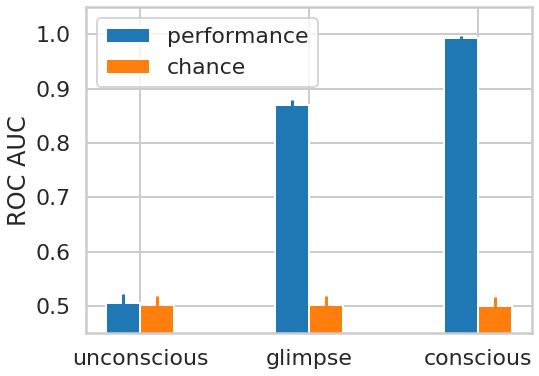

In [0]:
fig,ax = plt.subplots(figsize = (8,6))
ax.bar(df_results['visibility']-0.1,df_results['accuracy_mean'],width = 0.2,label='performance')
ax.errorbar(df_results['visibility']-0.1,
            df_results['accuracy_mean'],
            yerr=df_results['accuracy_std'],
            linestyle = '',
            )
ax.bar(df_results['visibility']+0.1,df_results['chance_mean'],width = 0.2, label='chance')
ax.errorbar(df_results['visibility']+0.1,
            df_results['chance_mean'],
            yerr=df_results['chance_std'],
            linestyle = '',
            )
ax.set(ylim = (0.45,1.05),
       ylabel = 'ROC AUC',
       xticks = [1,2,3],
       xticklabels = ['unconscious','glimpse','conscious'])
ax.legend(loc = 'upper left')

# post encoding:

1. predict BOLD using computational model features
2. 3 computer vision and 3 word embedding models
3. 15 ROIs

In [0]:
ls decode

encoding_model_15_ROIs/


In [0]:
working_dir = 'decode/encoding_model_15_ROIs'
working_data =  glob(os.path.join(working_dir,'*.csv'))
df = pd.concat([pd.read_csv(f) for f in working_data])
print(f'dataframe has {df.shape[0]} rows')

dataframe has 1458000 rows


In [0]:
df['roi_name'] = df['roi_name'].apply(lambda x:x.split('_')[-1])
roi_order = np.sort(pd.unique(df['roi_name']))
N = len(pd.unique(df['sub_name']))

In [0]:
hue_order = ['VGG19', 
             'DenseNet169', 
             'MobileNetV2', 
             'Word2Vec',
             'GloVe',
             'Fast Text',
             ]

In [0]:
df['model_name'] = df['model_name'].map({'fast text':'Fast Text',
                                         'glove':'GloVe',
                                         'word2vec':'Word2Vec',
                                         'concatenated_word2vec':'Word Embedding',
                                         'VGG19':'VGG19',
                                         'DenseNet169':'DenseNet169',
                                         'MobileNetV2':'MobileNetV2'})
df['Model'] = df['model_name'].map({'Fast Text':'W2V',
                                    'GloVe':'W2V',
                                    'Word2Vec':'W2V',
                                    'Word Embedding':'W2V',
                                    'VGG19':'I2V',
                                    'DenseNet169':'I2V',
                                    'MobileNetV2':'I2V'})
df['roi_name'] = df['roi_name'].map({'frontpole':'Frontal Pole', 
                                     'fusif':'Fusirorm Gyrus', 
                                     'infpar':'Inferior Parietal Lobe', 
                                     'inftemp':'Inferior Temporal Lobe', 
                                     'lofc':'Lateral Orbitofrontal Cortex', 
                                     'mofc':'Medial Orbitfrontal Cortex', 
                                     'mtemp':'Medial Temporal Lobe',
                                     'parsoper':'Pars Opercularis', 
                                     'parsorbi':'Pars Orbitalis', 
                                     'parstri':'Pars Triangularis', 
                                     'phipp':'Parahippocampal Gyrus', 
                                     'postcing':'Posterior Cingulate Gyrus', 
                                     'precun':'Precuneus',
                                     'sfrontal':'Superior Frontal Gyrus', 
                                     'tempole':'Anterior Temporal Lobe'})
df['roi_name_br'] = df['roi_name'].map({'Frontal Pole':'FP', 
                                        'Fusirorm Gyrus':'FFG', 
                                        'Inferior Parietal Lobe':'IPL', 
                                        'Inferior Temporal Lobe':'ITL', 
                                        'Lateral Orbitofrontal Cortex':'LOFC', 
                                        'Medial Orbitfrontal Cortex':'MOFC', 
                                        'Medial Temporal Lobe':'MTL',
                                        'Pars Opercularis':'POP', 
                                        'Pars Orbitalis':'POR', 
                                        'Pars Triangularis':'PTR', 
                                        'Parahippocampal Gyrus':'PHG', 
                                        'Posterior Cingulate Gyrus':'PCG', 
                                        'Precuneus':'Precuneus',
                                        'Superior Frontal Gyrus':'SFG', 
                                        'Anterior Temporal Lobe':'ATL'})

In [0]:
df = df.sort_values(['roi_name_br','condition','Model','model_name','sub_name'])
df['condition'] = df['condition'].map({'read':'Shallow Information Processing','reenact':'Deep Information Processing'})

## average over the folds (300 cv folds)

In [0]:
df = df.groupby(['roi_name_br','condition','Model','model_name','sub_name']).mean().reset_index()
print(f'dataframe has {df.shape[0]} rows')

dataframe has 4860 rows


In [0]:
metric_concern = 'mean_variance'
ylabel_1 = "Variance Explained"
ylabel_2 = "$\Delta$ Variance Explained"

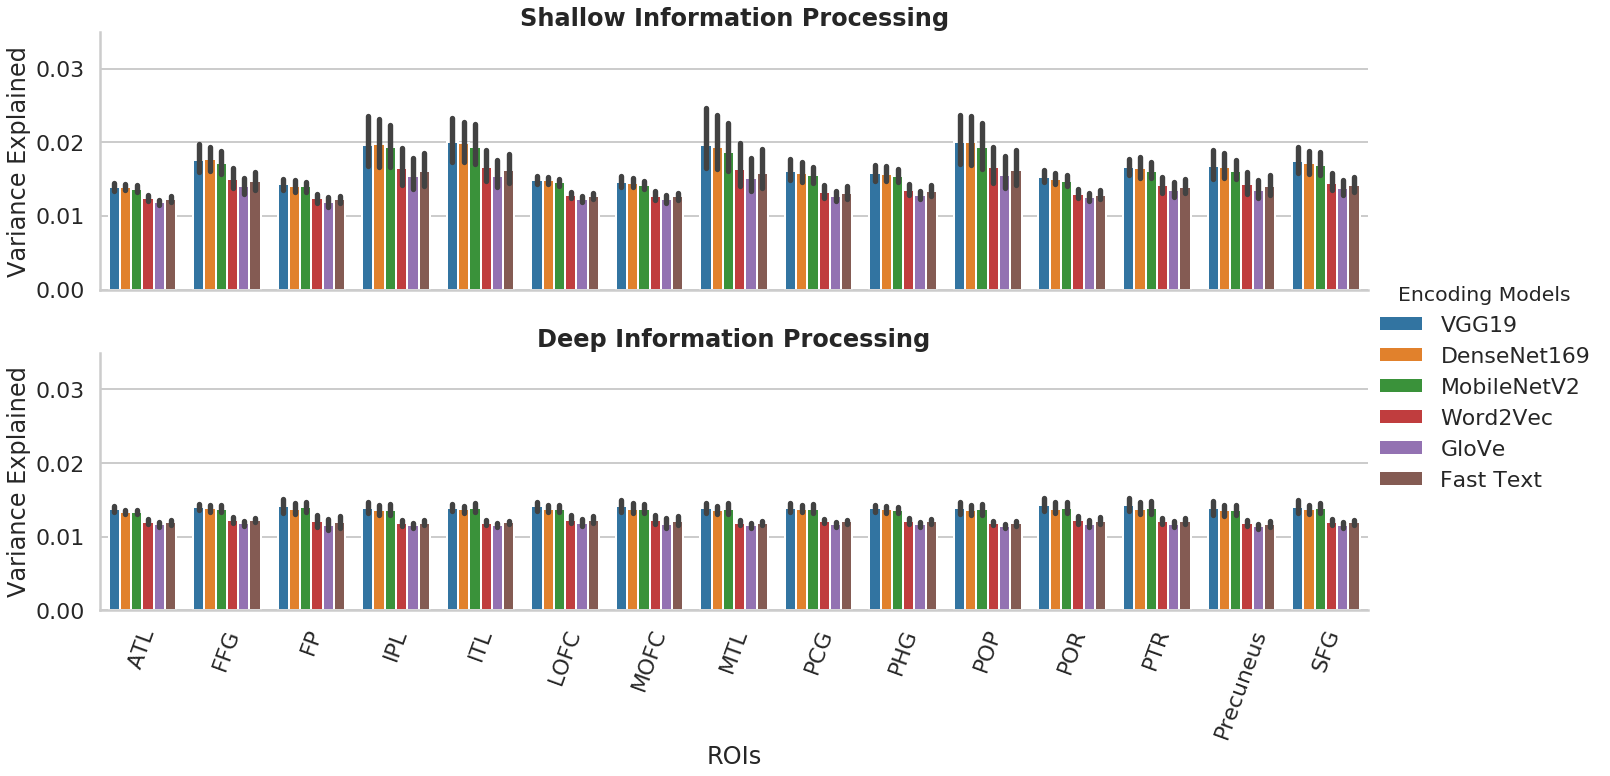

In [0]:
g = sns.catplot(x = 'roi_name_br',
                y = metric_concern,
                hue = 'model_name',
                hue_order = hue_order,
                row = 'condition',
                data = df,
                kind = 'bar',
                aspect = 4,
                sharey = True,)

g._legend.set_title('Encoding Models')
(g.set_axis_labels("ROIs",ylabel_1)
  .set_titles("{row_name}")
  .set(ylim = (0, 0.035))
  )
_=g.axes[0][0].set_title('Shallow Information Processing',fontweight='bold')
_=g.axes[1][0].set_title('Deep Information Processing',fontweight='bold')
_=plt.setp(g.axes.flatten()[1].xaxis.get_majorticklabels(), 
         rotation = 70 )

## Comparison between the computer vision and the word word embedding models

In [0]:
df_img = df[df['Model'] == 'I2V'].groupby(['condition','roi_name_br','sub_name','model_name']).mean().reset_index()
df_word = df[df['Model'] == 'W2V'].groupby(['condition','roi_name_br','sub_name','model_name']).mean().reset_index()

In [0]:
temp = []
for imageNet_model in pd.unique(df_img['model_name']):
    for word2vec_model in pd.unique(df_word['model_name']):
        df_image2vec = df_img[df_img['model_name'] == imageNet_model]
        df_word2vec = df_word[df_word['model_name'] == word2vec_model]
        var_mean_diff = df_image2vec[metric_concern].values - df_word2vec[metric_concern].values
        var_best_diff = df_image2vec['best_variance'].values - df_word2vec['best_variance'].values
        df_diff = df_image2vec.copy()
        df_diff[metric_concern] = var_mean_diff
        df_diff['best_variance'] = var_best_diff
        df_diff = df_diff[['condition',
                           'roi_name_br',
                           'sub_name',
                           'best_variance',
                           metric_concern]]
        df_diff['imageNet'] = imageNet_model
        df_diff['wordNet'] = word2vec_model
        temp.append(df_diff)

df_difference = pd.concat(temp)
df_difference['Model'] = df_difference['imageNet'] + ' - ' + df_difference['wordNet']

In [0]:
df_plot = pd.melt(df_difference,
                  id_vars = ['condition','roi_name_br','sub_name','Model'],
                  value_vars = [metric_concern,'best_variance'],
                  var_name = 'Variance Explained',
                  value_name = 'Differences of Variance Explained')
df_plot = df_plot.sort_values(['roi_name_br','condition','Model','sub_name'])

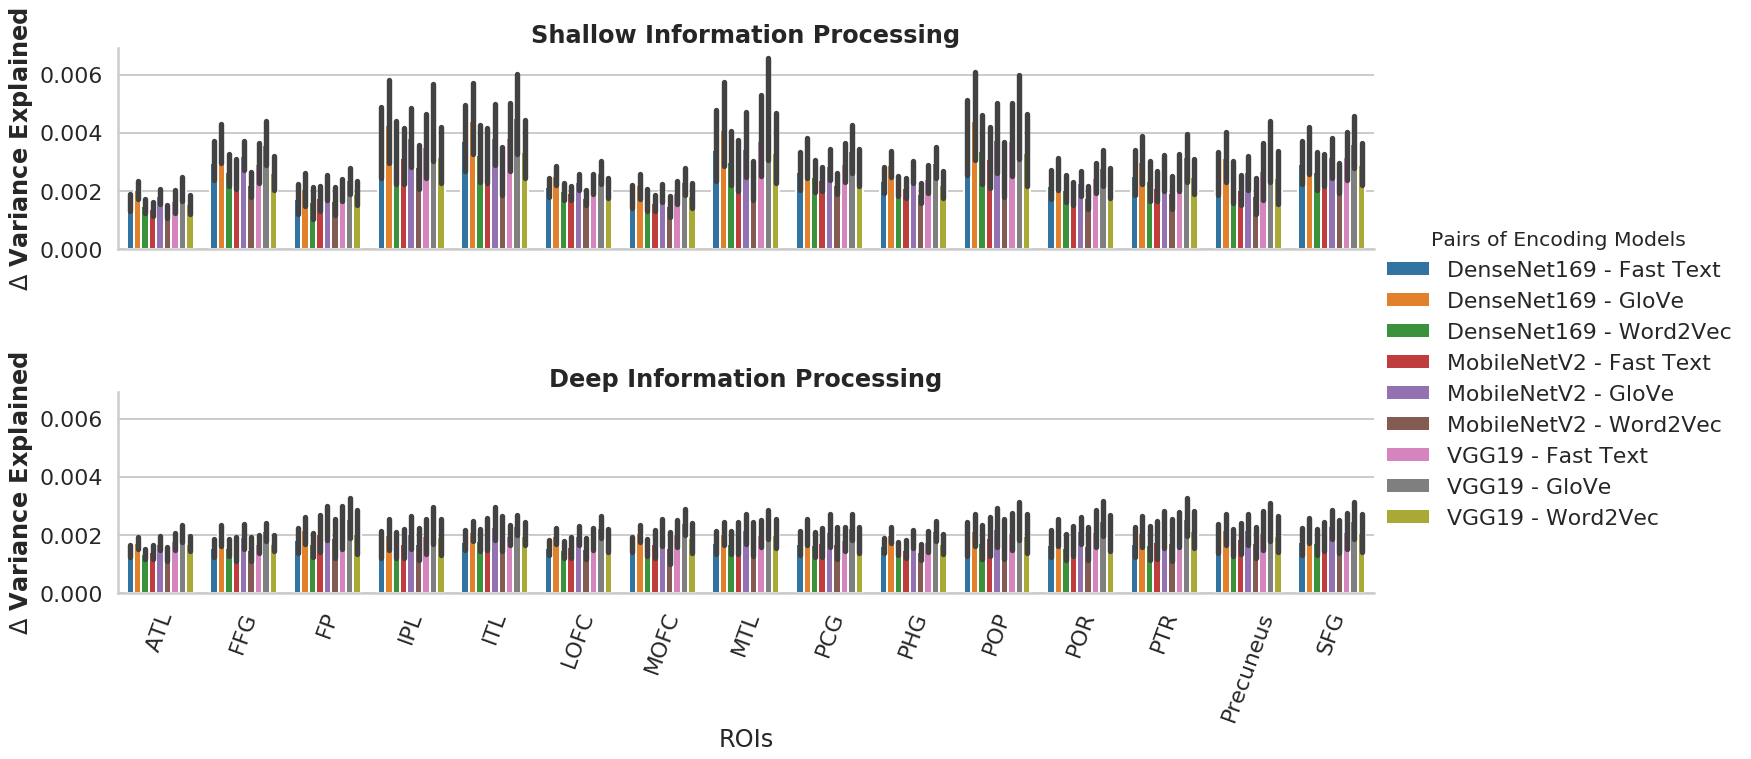

In [0]:
g = sns.catplot(x = 'roi_name_br',
                y = 'Differences of Variance Explained',
                hue = 'Model',
                hue_order = np.sort(pd.unique(df_plot['Model'])),
                row = 'condition',
                data = df_plot[df_plot['Variance Explained'] == metric_concern],
                kind = 'bar',
                aspect = 4,
                sharey = True,)
(g.set_axis_labels('ROIs',ylabel_2))
g._legend.set_title('Pairs of Encoding Models')
_=g.axes[0][0].set_title('Shallow Information Processing',fontweight='bold')
_=g.axes[0][0].set_ylabel(ylabel_2,fontweight='bold')
_=g.axes[1][0].set_title('Deep Information Processing',fontweight='bold')
_=g.axes[1][0].set_ylabel(ylabel_2,fontweight='bold')
_=plt.setp(g.axes.flatten()[1].xaxis.get_majorticklabels(), 
           rotation = 70 )

## comparison between condition (subplot 1 and subplot 2) for each ROI

In [0]:
d = df_img.groupby(['condition','roi_name_br','sub_name']).mean().reset_index()[metric_concern] -\
    df_word.groupby(['condition','roi_name_br','sub_name']).mean().reset_index()[metric_concern]
df_cc = df_img.groupby(['condition','roi_name_br','sub_name']).mean().reset_index().copy()
df_cc[metric_concern] = d.values

In [0]:
df_diff_diff = dict(
        roi = [],
        t = [],
        p = [],
        diff_mean = [],
        diff_std = [],)
for roi,df_sub in df_cc.groupby(['roi_name_br']):
    df_read = df_sub[df_sub['condition'] == 'Shallow Information Processing']
    df_reenact = df_sub[df_sub['condition'] == 'Deep Information Processing']
    a = df_read[metric_concern].values
    b = df_reenact[metric_concern].values
    #ps = resample_ttest(a - b, baseline = 0,one_tail = True)
    t,p = stats.ttest_rel(a,b)
    df_diff_diff['roi'].append(roi)
    df_diff_diff['t'].append(t)
    df_diff_diff['p'].append(p)
    df_diff_diff['diff_mean'].append(np.mean(np.abs(a - b)))
    df_diff_diff['diff_std'].append(np.std(np.abs(a - b)))
df_diff_diff = pd.DataFrame(df_diff_diff)

In [0]:
df_diff_diff = df_diff_diff.sort_values(['p'])
pvals = df_diff_diff['p'].values
ps_corrected = multipletests(pvals,method='fdr_bh',is_sorted=True)
df_diff_diff['ps_corrected'] = ps_corrected[1]

In [0]:
def stars(x):
    if x < 0.001:
        return '***'
    elif x < 0.01:
        return '**'
    elif x < 0.05:
        return '*'
    else:
        return 'n.s.'

In [0]:
df_diff_diff['star'] = df_diff_diff['ps_corrected'].apply(stars)

In [0]:
df_cc = df_cc.sort_values(['roi_name_br'])
df_diff_diff = df_diff_diff.sort_values(['roi'])

In [0]:
unique_rois = pd.unique(df_cc['roi_name_br'])
n_axis = {name:ii < 7 for ii,name in enumerate(unique_rois)}
df_cc['subplots'] = df_cc['roi_name_br'].map(n_axis)
df_diff_diff['subplots'] = df_diff_diff['roi'].map(n_axis)

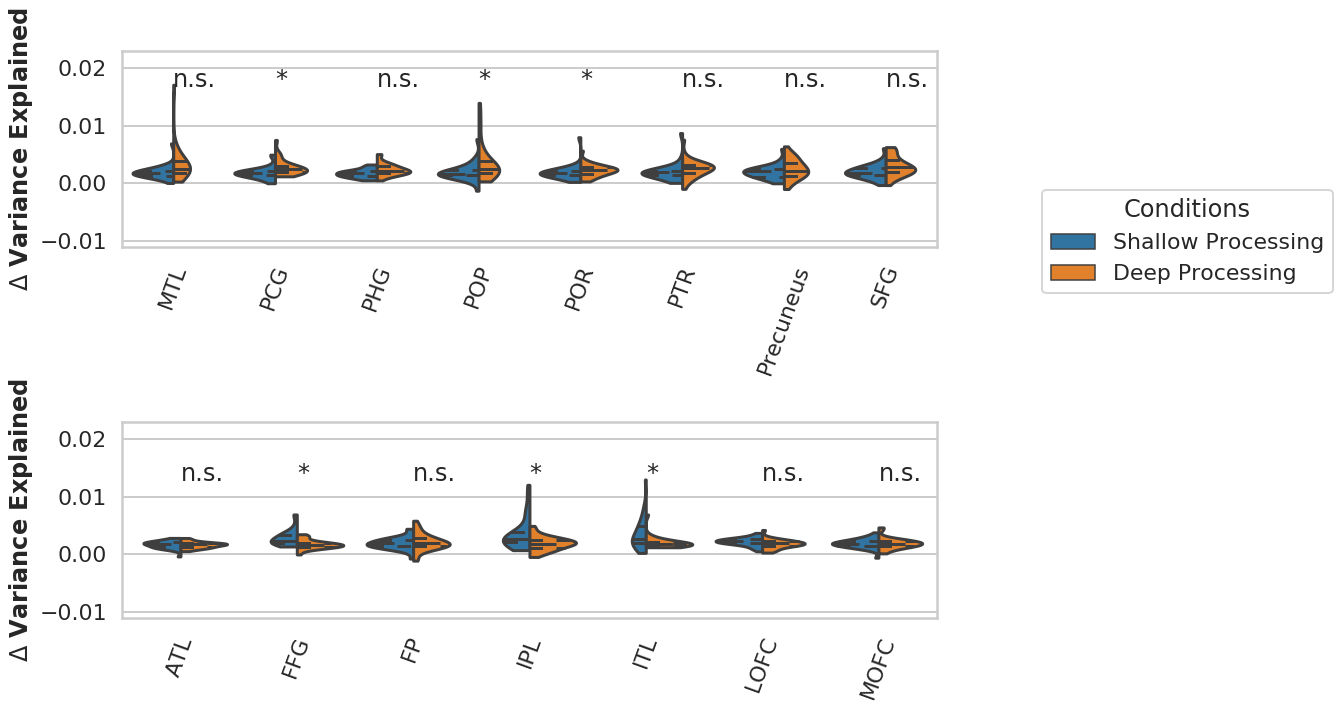

In [0]:
lim_thres = 0.01
text_thres = 0.0003
fig,axes = plt.subplots(figsize = (22,10),nrows = 2,
                        sharey = True)
for (subplot,df_sub),ax in zip(df_cc.groupby(['subplots']),axes):
    df_diff_diff_sub = df_diff_diff[df_diff_diff['subplots'] == subplot]
    ax = sns.violinplot(x = 'roi_name_br',
                        y = metric_concern,
                        hue = 'condition',
                        split = True,
                        cut = 0,
                        inner = 'quartile',
                        data = df_sub,
                        ax = ax)
    ax.set(xlabel = '',ylabel = ylabel_2,
               ylim = (df_sub[metric_concern].min() - lim_thres,
                       df_sub[metric_concern].max() + lim_thres)
           )
    ax.set_ylabel(ylabel_2,fontweight = 'bold')
    plt.setp(ax.xaxis.get_majorticklabels(), 
         rotation = 70 )
    ax.legend(bbox_to_anchor=(1.5, 0.35))
    ax.get_legend().set_title('Conditions')
    ax.get_legend().texts[0].set_text('Shallow Processing')
    ax.get_legend().texts[1].set_text('Deep Processing')
    for ii in range(len(pd.unique(df_sub['roi_name_br']))):
        text = ax.annotate(df_diff_diff['star'].values[ii],
                           xy = (ii,df_sub[metric_concern].max()-text_thres))
    if subplot > 0:
        ax.get_legend().remove()
fig.tight_layout()